## notebook purpose

- add tv loss, tune hparam lambda_tv
- conclusion
    - adding lambda_tv=1e-8 results in improvement for e2, but e1 is the same
    - lambda_tv=5e-8 gives better quant but worse qual results
    - higher lambda_tv is worse quant/qual
    - lower lambda_tv makes no difference

In [4]:
import os, sys
import numpy as np
from os import listdir
from os.path import isfile, join, isdir
import matplotlib.pyplot as plt
import h5py
import sigpy
from sigpy.mri.samp import poisson
import torch

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.data_io import load_h5_qdess, num_params
from include.decoder_conv import init_convdecoder
from include.fit import fit
from utils.evaluate import calc_metrics
from utils.transform import fft_2d, ifft_2d, root_sum_squares, \
                            reshape_complex_vals_to_adj_channels, \
                            reshape_adj_channels_to_complex_vals

In [9]:
def get_file_list(path):
    return [f for f in listdir(path) if isfile(join(path,f))]

path = '/bmrNAS/people/dvv/out_qdess/accel_8x/echo_joint/'

files_re = [f for f in get_file_list(path) if 'tv1e-08' in f]

for f in files_re:
    
    arr = np.load(path + f)
    f_re = f.split('_tv1')[0]
    np.save(path + f_re, arr)

In [3]:
def plot_list(arr_list, title_list, clim=(0,1)):#None):
    
    SF = 2.56 # stretch factor
    NUM_COLS = len(arr_list)
    
    fig = plt.figure(figsize=(20,20))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray', clim=clim, aspect=1./SF)
        ax.set_title(title_list[idx], fontsize=20)
        ax.axis('off')

In [4]:
id_list = ['005', '006', '030', '034', '048', '052', '065', 
           '080', '096', '099', '120', '144', '156', '158',
           '176', '178']

### findings so far

- 1e-7: too much tv
- 5e-8: significant improvements for e2 + minor improvement for e1 (except in vif, again. note this relationship)
- 1e-8, 1e-9, 5e-9: same affects as 5e-8, but less pronounced
- 1e-10: no effect

In [5]:
e_num_list = [1,2]
accel_list = [4]
LAMBDA_TV_LIST = [1e-8, 5e-8]

NUM_SAMPS = len(id_list)
NUM_ECHOS = len(e_num_list)
NUM_TYPES = 4 # types of image to plot on each line, e.g. gt, baseline, new, diff
NUM_VARS = len(LAMBDA_TV_LIST) # len(accel_list) # i.e. for each sample, compare at these variants
NUM_METRICS = 4

im_list = np.empty((NUM_SAMPS, NUM_ECHOS, NUM_VARS, NUM_TYPES, 512, 160))

# for accel in accel_list:
accel = 8
for idx_v, lam_tv in enumerate(LAMBDA_TV_LIST):

    path_bl = '/bmrNAS/people/dvv/out_qdess/accel_{}x/echo_joint/'.format(accel) # baseline method
    path_new = path_bl + 'loss_tv_tune/' # new method against which we're comparing

    metrics_bl = np.empty((NUM_ECHOS, NUM_SAMPS, NUM_METRICS))
    metrics_new = np.empty((NUM_ECHOS, NUM_SAMPS, NUM_METRICS))

    for idx, id_ in enumerate(id_list):

        for idx_e, e_num in enumerate(e_num_list):
            
            path_q = '/bmrNAS/people/dvv/out_qdess/accel_{}x/'.format(accel)

            im_gt = np.load('{}MTR_{}_e{}_gt.npy'.format(path_bl, id_, e_num))  

            im_dc = np.load('{}MTR_{}_e{}_dc.npy'.format(path_bl, id_, e_num))  
            im_lo_tv = np.load('{}MTR_{}_e{}_dc_tv1e-08.npy'.format(path_new, id_, e_num))
            im_hi_tv = np.load('{}MTR_{}_e{}_dc_tv5e-08.npy'.format(path_new, id_, e_num))
            im_dc_new = np.load('{}MTR_{}_e{}_dc_tv{}.npy'.format(path_new, id_, e_num, lam_tv))
            
            # normalize to be on range of [0,1]
            im_gt, im_dc = im_gt/im_gt.max(), im_dc/im_dc.max() 
            im_lo_tv, im_hi_tv = im_lo_tv/im_lo_tv.max(), im_hi_tv/im_hi_tv.max() 
            im_dc_new = im_dc_new/im_dc_new.max()

            metrics_bl[idx_e][idx] = calc_metrics(im_gt, im_dc)
            metrics_new[idx_e][idx] = calc_metrics(im_gt, im_dc_new)

            C = 4
            im_diff = C * (im_dc - im_dc_new)
            
#             im_list[idx][idx_e][idx_v] = np.array([im_gt, im_dc, im_dc_new, im_diff])
            im_list[idx][idx_e][idx_v] = np.array([im_gt, im_dc, im_lo_tv, im_hi_tv])

    perc_diff_list = (metrics_new - metrics_bl) / metrics_bl

    vals_bl = np.mean(metrics_bl, axis=1)
    vals_new = np.mean(metrics_new, axis=1)
    perc_diff = np.mean(perc_diff_list, axis=1)
    
#     print('accel {}x \n'.format(accel))
    print('lambda_tv: {} \n'.format(lam_tv))
    print('recon bl method')
    print(vals_bl, '\n')
    print('recon new method')
    print(vals_new, '\n')
    print('perc diff')
    print(perc_diff)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')

/home/vanveen/heck/lib/python3.8/site-packages/pytorch_msssim/ssim.py:50: UserWarning: Skipping Gaussian Smoothing at dimension 2+1 for input: torch.Size([1, 1, 32, 10]) and win size: 11
  warnings.warn(


lambda_tv: 1e-08 

recon bl method
[[ 0.86801733  0.95621845  0.81082036 30.67179888]
 [ 0.68781378  0.89791344  0.69189226 30.59311346]] 

recon new method
[[ 0.86194368  0.96444742  0.83783147 31.5178101 ]
 [ 0.73073369  0.93108752  0.7577015  32.16151355]] 

perc diff
[[-0.00677175  0.00860965  0.03331633  0.02761908]
 [ 0.07159354  0.0373209   0.09716413  0.05158194]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

lambda_tv: 5e-08 

recon bl method
[[ 0.86801733  0.95621845  0.81082036 30.67179888]
 [ 0.68781378  0.89791344  0.69189226 30.59311346]] 

recon new method
[[ 0.8209178   0.96757121  0.84958692 31.08828174]
 [ 0.73403368  0.94547983  0.77990103 32.45891705]] 

perc diff
[[-0.05407452  0.01189322  0.04810372  0.01348019]
 [ 0.08097685  0.05361538  0.13025609  0.0616329 ]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



SystemExit: 

/home/vanveen/heck/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


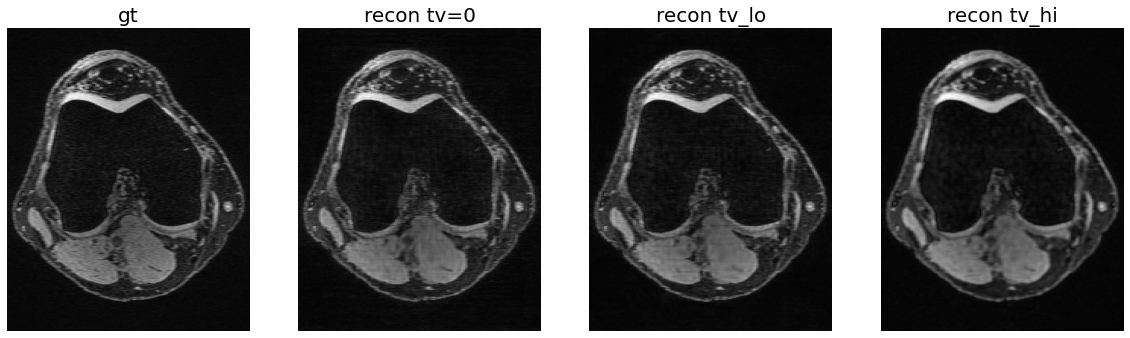

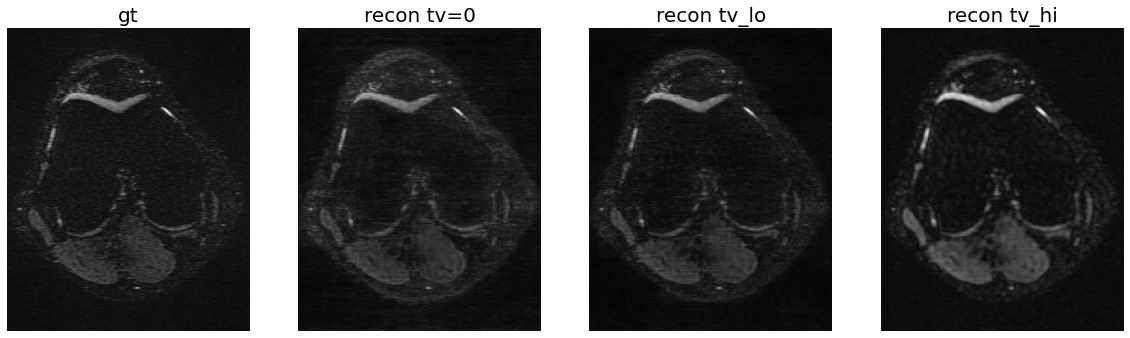

In [6]:
# title_list = ['gt', 'recon bl method', 'recon new method', 'diff(bl, new)']
title_list = ['gt', 'recon tv=0', 'recon tv_lo', 'recon tv_hi']

im_list = im_list[:,:,0,:,:,:][:,:,None,:,:,:] # get rid of duplicates


for idx_s, _ in enumerate(im_list):
    for idx_e, _ in enumerate(im_list[idx_s]):
        for v in im_list[idx_s][idx_e]:
            plot_list(v, title_list)
    sys.exit()